Training baseline model...

Evaluating test_iid...

Evaluating test_weather...

Evaluating test_holiday...
Logistics Delay Prediction Experiment Report

Metrics Summary Table:
        test_set       configuration     auc     ece  rejection_rate  \
0       test_iid            baseline  0.9344  0.0555          0.0000   
1       test_iid         calibration  0.9303  0.0100          0.0000   
2       test_iid           rejection  0.9348  0.0063          0.0760   
3       test_iid  causal_sensitivity  0.9348  0.0063          0.0760   
4       test_iid   policy_estimation  0.9348  0.0063          0.0760   
5   test_weather            baseline  0.8623  0.0827          0.0000   
6   test_weather         calibration  0.8521  0.0394          0.0000   
7   test_weather           rejection  0.8481  0.0381          0.0994   
8   test_weather  causal_sensitivity  0.8481  0.0381          0.0994   
9   test_weather   policy_estimation  0.8481  0.0381          0.0994   
10  test_holiday            base

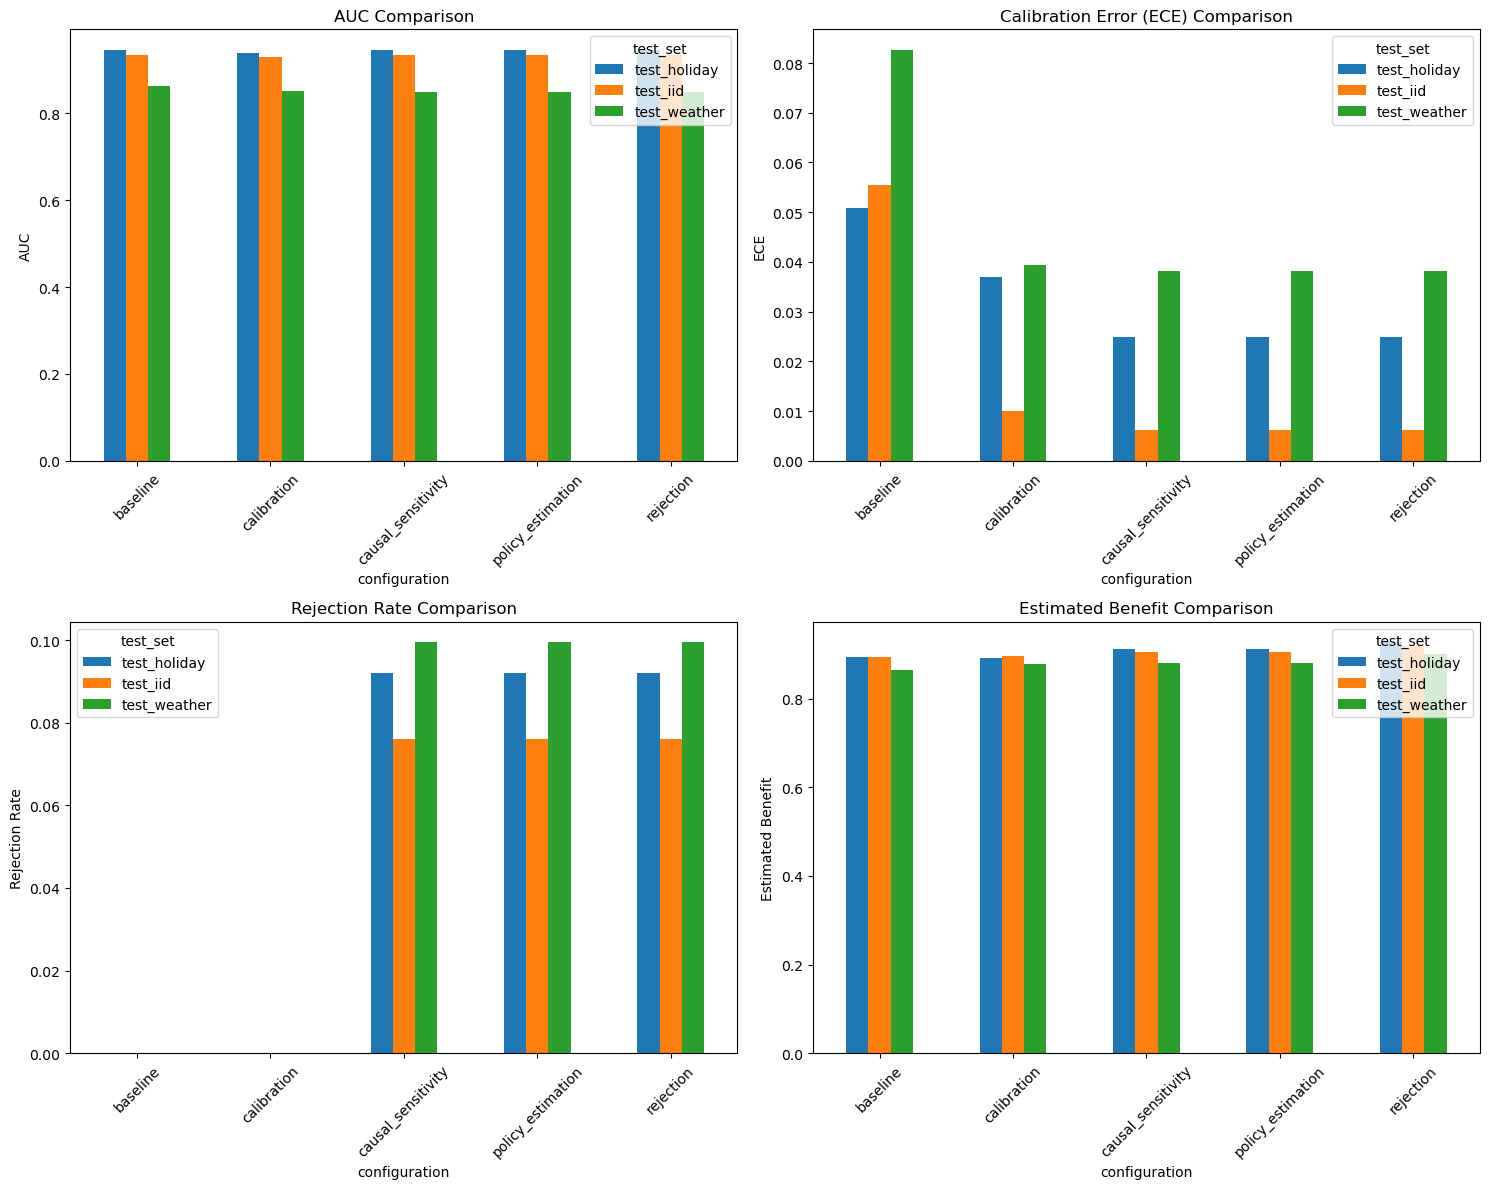

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.calibration import calibration_curve
from sklearn.isotonic import IsotonicRegression
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import bernoulli

# Set random seed for reproducibility
np.random.seed(42)

class LogisticsDelayExperiment:
    def __init__(self):
        self.models = {}
        self.results = {}
        
    def load_and_prepare_data(self):
        """Load data and prepare various splits"""
        df = pd.read_csv('logistics_delay_dataset.csv')
        
        # Basic splits
        train_df = df[df['split'] == 'train'].copy()
        val_iid_df = df[df['split'] == 'val_iid'].copy()
        test_iid_df = df[df['split'] == 'test_iid'].copy()
        
        # OOD splits
        test_weather_df = df[df['split'] == 'test_extreme_weather'].copy()
        test_holiday_df = df[df['split'] == 'test_holiday'].copy()
        
        # Features and labels
        feature_cols = ['weather_severity', 'traffic_congestion', 'warehouse_congestion', 
                       'driver_experience', 'truck_allocation', 'route_complexity',
                       'package_volume', 'time_sensitivity', 'day_of_week', 'month']
        
        # Prepare datasets
        datasets = {
            'train': (train_df[feature_cols], train_df['delayed']),
            'val_iid': (val_iid_df[feature_cols], val_iid_df['delayed']),
            'test_iid': (test_iid_df[feature_cols], test_iid_df['delayed']),
            'test_weather': (test_weather_df[feature_cols], test_weather_df['delayed']),
            'test_holiday': (test_holiday_df[feature_cols], test_holiday_df['delayed'])
        }
        
        return datasets, feature_cols
    
    def expected_calibration_error(self, y_true, y_prob, n_bins=10):
        """Calculate Expected Calibration Error"""
        bin_edges = np.linspace(0, 1, n_bins + 1)
        bin_indices = np.digitize(y_prob, bin_edges) - 1
        bin_indices = np.clip(bin_indices, 0, n_bins - 1)
        
        ece = 0.0
        for bin_idx in range(n_bins):
            mask = bin_indices == bin_idx
            if np.sum(mask) > 0:
                bin_acc = np.mean(y_true[mask])
                bin_conf = np.mean(y_prob[mask])
                bin_weight = np.sum(mask) / len(y_true)
                ece += bin_weight * np.abs(bin_acc - bin_conf)
        
        return ece
    
    def train_baseline(self, X_train, y_train):
        """Train baseline model"""
        model = GradientBoostingClassifier(
            n_estimators=100,
            max_depth=6,
            random_state=42
        )
        model.fit(X_train, y_train)
        return model
    
    def apply_calibration(self, model, X_val, y_val, X_test):
        """Apply isotonic regression calibration"""
        # Get validation set predicted probabilities
        val_probs = model.predict_proba(X_val)[:, 1]
        
        # Apply isotonic regression for calibration
        calibrator = IsotonicRegression(out_of_bounds='clip')
        calibrator.fit(val_probs, y_val)
        
        # Calibrate test set predictions
        test_probs = model.predict_proba(X_test)[:, 1]
        calibrated_probs = calibrator.transform(test_probs)
        
        return calibrated_probs
    
    def apply_rejection(self, y_prob, threshold=0.7):
        """Apply rejection mechanism"""
        confident_mask = (y_prob >= threshold) | (y_prob <= (1 - threshold))
        rejection_rate = 1 - np.mean(confident_mask)
        
        # Only make final classifications on confident predictions
        y_pred_confident = (y_prob[confident_mask] > 0.5).astype(int)
        
        return confident_mask, rejection_rate, y_pred_confident
    
    def causal_sensitivity_analysis(self, model, X_test, actionable_feature='truck_allocation'):
        """Causal sensitivity analysis"""
        # Create intervention scenario: increase truck allocation
        X_intervention = X_test.copy()
        original_values = X_test[actionable_feature].copy()
        
        # Intervention: increase truck allocation (business actionable direction)
        X_intervention[actionable_feature] = np.clip(original_values + 0.2, 0, 1)
        
        # Predict delay probabilities before and after intervention
        original_probs = model.predict_proba(X_test)[:, 1]
        intervention_probs = model.predict_proba(X_intervention)[:, 1]
        
        # Calculate average change (should be negative, indicating reduced delays)
        sensitivity_score = np.mean(intervention_probs - original_probs)
        
        return sensitivity_score, original_probs, intervention_probs
    
    def policy_estimation(self, y_true, y_pred, intervention_effect):
        """Policy benefit estimation"""
        # Simplified benefit estimation: combination of accuracy and intervention effect
        accuracy = accuracy_score(y_true, y_pred)
        estimated_benefit = accuracy * (1 - intervention_effect)
        
        return estimated_benefit
    
    def run_experiment(self):
        """Run complete experiment"""
        datasets, feature_cols = self.load_and_prepare_data()
        X_train, y_train = datasets['train']
        
        # Train baseline model
        print("Training baseline model...")
        baseline_model = self.train_baseline(X_train, y_train)
        self.models['baseline'] = baseline_model
        
        # List of test sets
        test_sets = ['test_iid', 'test_weather', 'test_holiday']
        
        for test_set in test_sets:
            print(f"\nEvaluating {test_set}...")
            X_test, y_test = datasets[test_set]
            
            results = {}
            
            # 1. Baseline
            baseline_probs = baseline_model.predict_proba(X_test)[:, 1]
            baseline_preds = (baseline_probs > 0.5).astype(int)
            
            results['baseline'] = {
                'auc': roc_auc_score(y_test, baseline_probs),
                'ece': self.expected_calibration_error(y_test, baseline_probs),
                'rejection_rate': 0.0,
                'estimated_benefit': accuracy_score(y_test, baseline_preds)
            }
            
            # 2. + Calibration
            calibrated_probs = self.apply_calibration(baseline_model, *datasets['val_iid'], X_test)
            calibrated_preds = (calibrated_probs > 0.5).astype(int)
            
            results['calibration'] = {
                'auc': roc_auc_score(y_test, calibrated_probs),
                'ece': self.expected_calibration_error(y_test, calibrated_probs),
                'rejection_rate': 0.0,
                'estimated_benefit': accuracy_score(y_test, calibrated_preds)
            }
            
            # 3. + Rejection
            confident_mask, rejection_rate, _ = self.apply_rejection(calibrated_probs)
            y_test_confident = y_test[confident_mask]
            calibrated_probs_confident = calibrated_probs[confident_mask]
            
            results['rejection'] = {
                'auc': roc_auc_score(y_test_confident, calibrated_probs_confident),
                'ece': self.expected_calibration_error(y_test_confident, calibrated_probs_confident),
                'rejection_rate': rejection_rate,
                'estimated_benefit': accuracy_score(y_test_confident, (calibrated_probs_confident > 0.5).astype(int))
            }
            
            # 4. + Causal Sensitivity
            sensitivity_score, _, _ = self.causal_sensitivity_analysis(baseline_model, X_test)
            
            results['causal_sensitivity'] = {
                'auc': results['rejection']['auc'],
                'ece': results['rejection']['ece'],
                'rejection_rate': results['rejection']['rejection_rate'],
                'sensitivity_score': sensitivity_score,
                'estimated_benefit': results['rejection']['estimated_benefit'] * (1 - sensitivity_score)
            }
            
            # 5. + Policy Estimation
            policy_benefit = self.policy_estimation(y_test_confident, 
                                                   (calibrated_probs_confident > 0.5).astype(int),
                                                   sensitivity_score)
            
            results['policy_estimation'] = {
                'auc': results['causal_sensitivity']['auc'],
                'ece': results['causal_sensitivity']['ece'],
                'rejection_rate': results['causal_sensitivity']['rejection_rate'],
                'sensitivity_score': sensitivity_score,
                'estimated_benefit': policy_benefit
            }
            
            self.results[test_set] = results
        
        return self.results
    
    def generate_report(self):
        """Generate experiment report"""
        print("=" * 80)
        print("Logistics Delay Prediction Experiment Report")
        print("=" * 80)
        
        metrics_df = []
        
        for test_set, results in self.results.items():
            for config, metrics in results.items():
                row = {
                    'test_set': test_set,
                    'configuration': config,
                    'auc': metrics.get('auc', 0),
                    'ece': metrics.get('ece', 0),
                    'rejection_rate': metrics.get('rejection_rate', 0),
                    'sensitivity_score': metrics.get('sensitivity_score', 0),
                    'estimated_benefit': metrics.get('estimated_benefit', 0)
                }
                metrics_df.append(row)
        
        metrics_df = pd.DataFrame(metrics_df)
        
        # Print metrics table
        print("\nMetrics Summary Table:")
        print(metrics_df.round(4))
        
        # Visualize results
        self.plot_results(metrics_df)
        
        return metrics_df
    
    def plot_results(self, metrics_df):
        """Plot result charts"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # AUC comparison
        pivot_auc = metrics_df.pivot(index='configuration', columns='test_set', values='auc')
        pivot_auc.plot(kind='bar', ax=axes[0,0], title='AUC Comparison')
        axes[0,0].set_ylabel('AUC')
        axes[0,0].tick_params(axis='x', rotation=45)
        
        # ECE comparison
        pivot_ece = metrics_df.pivot(index='configuration', columns='test_set', values='ece')
        pivot_ece.plot(kind='bar', ax=axes[0,1], title='Calibration Error (ECE) Comparison')
        axes[0,1].set_ylabel('ECE')
        axes[0,1].tick_params(axis='x', rotation=45)
        
        # Rejection rate comparison
        pivot_reject = metrics_df.pivot(index='configuration', columns='test_set', values='rejection_rate')
        pivot_reject.plot(kind='bar', ax=axes[1,0], title='Rejection Rate Comparison')
        axes[1,0].set_ylabel('Rejection Rate')
        axes[1,0].tick_params(axis='x', rotation=45)
        
        # Estimated benefit comparison
        pivot_benefit = metrics_df.pivot(index='configuration', columns='test_set', values='estimated_benefit')
        pivot_benefit.plot(kind='bar', ax=axes[1,1], title='Estimated Benefit Comparison')
        axes[1,1].set_ylabel('Estimated Benefit')
        axes[1,1].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.savefig('experiment_results.png', dpi=300, bbox_inches='tight')
        plt.show()

# Run the experiment
experiment = LogisticsDelayExperiment()
results = experiment.run_experiment()
metrics_table = experiment.generate_report()

Starting failure case analysis...

Failure Case Analysis - test_iid

--- baseline Configuration ---
Total samples: 750
Misclassified: 79
Accuracy: 0.895
False Positives (over-predicted delays): 42
False Negatives (missed delays): 37

Failure Case Pattern Analysis (total 79 failure cases):

False Positive Case Feature Analysis (42 cases):
Average feature values:
  Weather severity: 1.070
  Traffic congestion: -1.015
  Warehouse congestion: 1.347
  Truck allocation: 1.058
  Average confidence: 0.770

False Negative Case Feature Analysis (37 cases):
Average feature values:
  Weather severity: -0.463
  Traffic congestion: -0.584
  Warehouse congestion: 0.894
  Truck allocation: 1.821
  Average confidence: 0.657

--- calibration Configuration ---
Total samples: 750
Misclassified: 78
Accuracy: 0.896
False Positives (over-predicted delays): 48
False Negatives (missed delays): 30

Failure Case Pattern Analysis (total 78 failure cases):

False Positive Case Feature Analysis (48 cases):
Average 

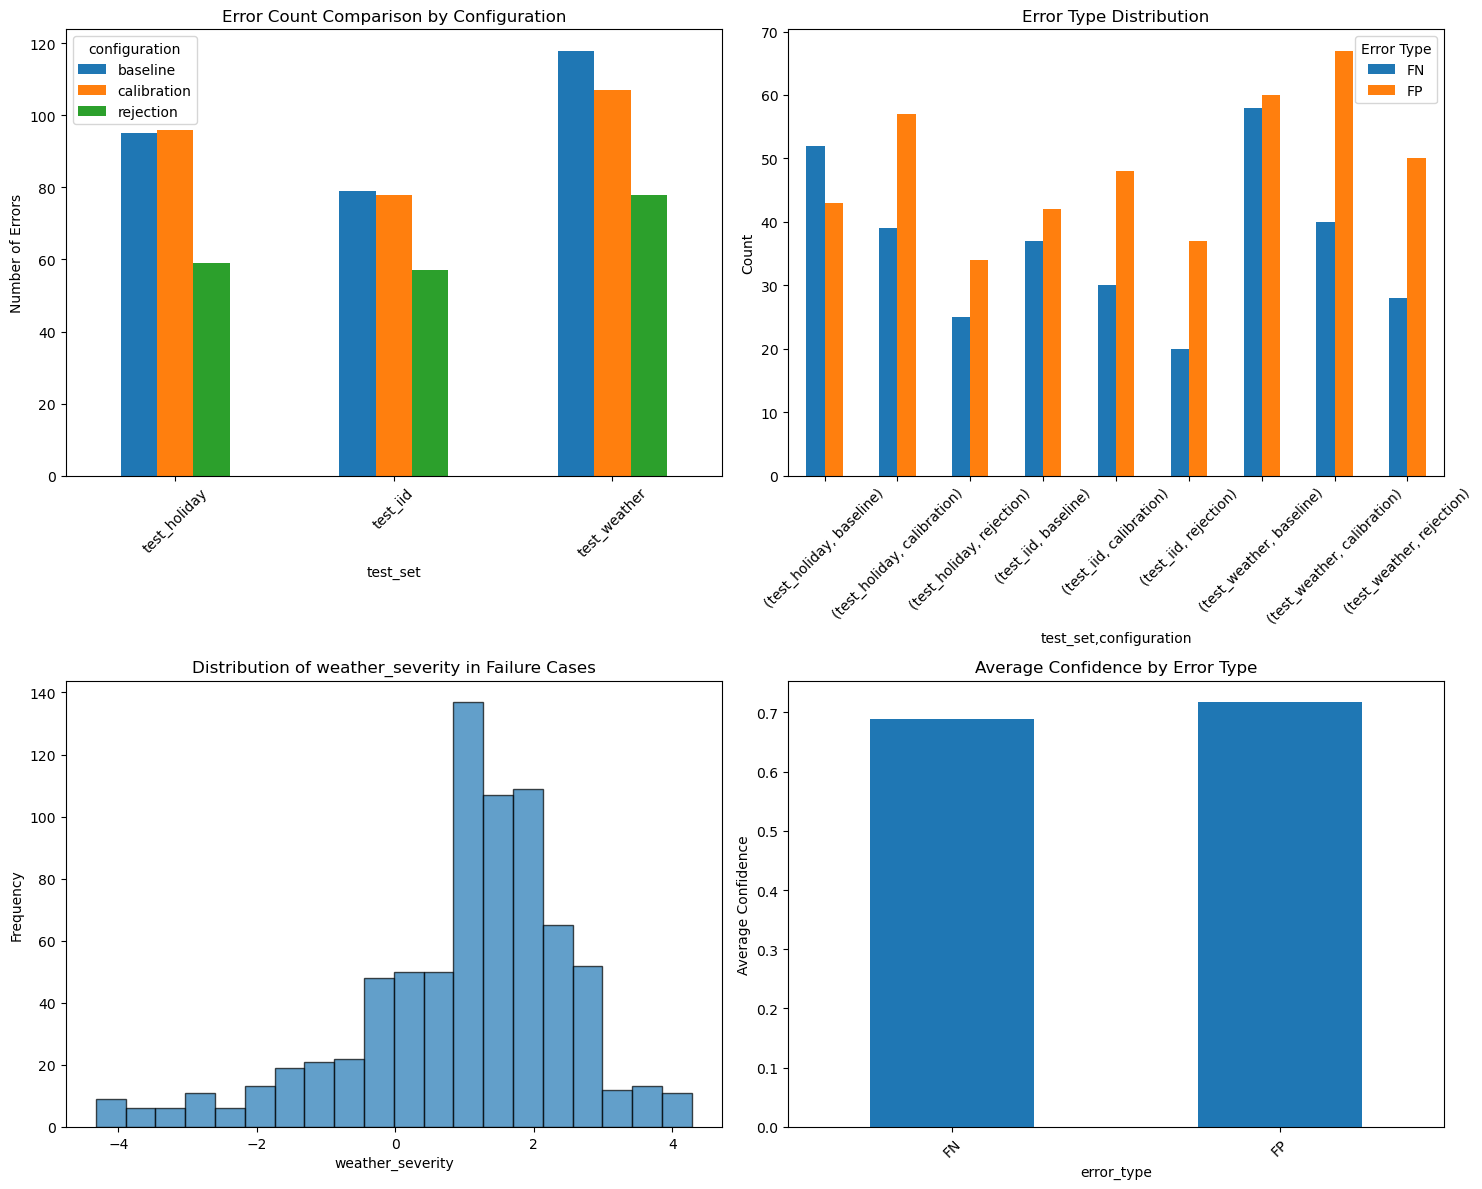


Typical Case Analysis

FN Typical Case (Confidence: 1.000):
  Test set: test_weather
  Configuration: calibration
  True: Delayed
  Predicted: On Time
  Prediction probability: 0.000
  Key features:
    Weather: 2.157723968338206
    Traffic: -2.27
    Warehouse: 3.99
    Truck: -1.55
    Route complexity: -0.83

FP Typical Case (Confidence: 0.993):
  Test set: test_weather
  Configuration: baseline
  True: On Time
  Predicted: Delayed
  Prediction probability: 0.997
  Key features:
    Weather: 2.2084282464651963
    Traffic: -1.88
    Warehouse: 1.16
    Truck: 1.16
    Route complexity: 3.49


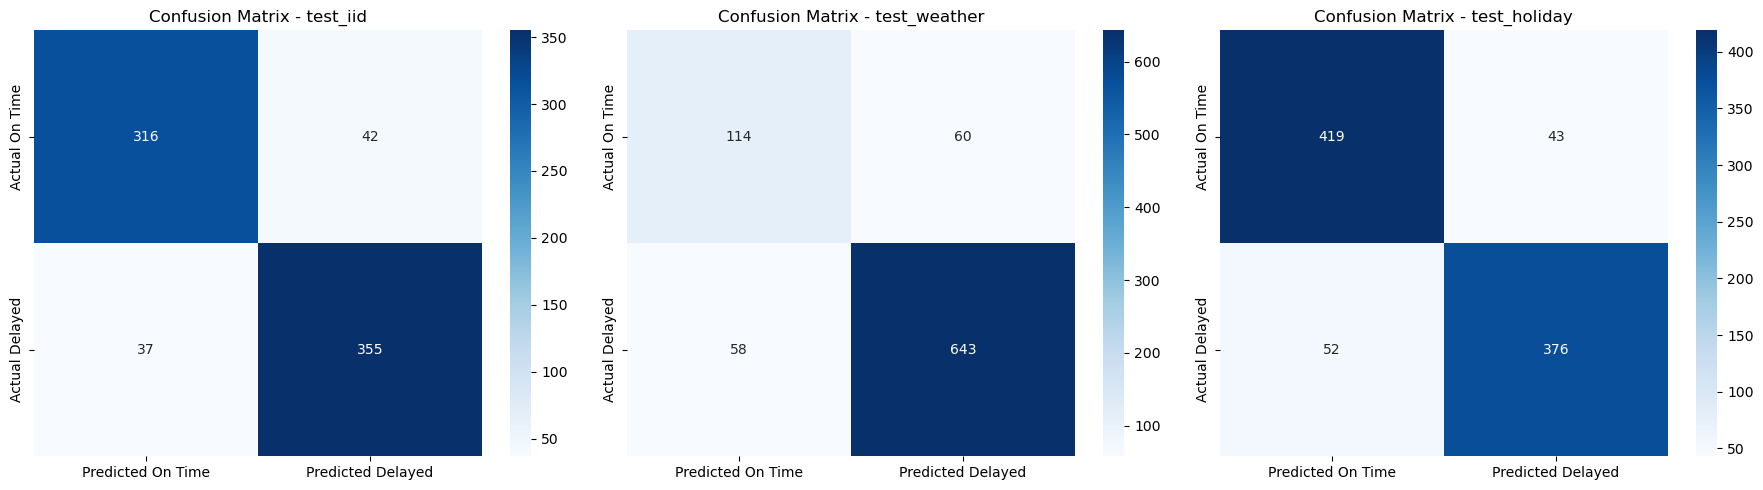

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

class FailureCaseAnalyzer:
    def __init__(self, model, dataset):
        self.model = model
        self.dataset = dataset
        self.failure_cases = {}
    
    def analyze_failures_across_configs(self, experiment_results, feature_cols):
        """Analyze failure cases across all configurations and test sets"""
        datasets, _ = experiment_results.load_and_prepare_data()
        
        failure_analysis = {}
        
        test_sets = ['test_iid', 'test_weather', 'test_holiday']
        configs = ['baseline', 'calibration', 'rejection']
        
        for test_set in test_sets:
            print(f"\n{'='*60}")
            print(f"Failure Case Analysis - {test_set}")
            print(f"{'='*60}")
            
            X_test, y_test = datasets[test_set]
            failure_analysis[test_set] = {}
            
            for config in configs:
                print(f"\n--- {config} Configuration ---")
                
                if config == 'baseline':
                    probs = experiment_results.models['baseline'].predict_proba(X_test)[:, 1]
                    preds = (probs > 0.5).astype(int)
                    confident_mask = np.ones_like(preds, dtype=bool)  # All confident
                    
                elif config == 'calibration':
                    calibrated_probs = experiment_results.apply_calibration(
                        experiment_results.models['baseline'], 
                        *datasets['val_iid'], X_test
                    )
                    preds = (calibrated_probs > 0.5).astype(int)
                    confident_mask = np.ones_like(preds, dtype=bool)
                    probs = calibrated_probs
                    
                elif config == 'rejection':
                    calibrated_probs = experiment_results.apply_calibration(
                        experiment_results.models['baseline'], 
                        *datasets['val_iid'], X_test
                    )
                    confident_mask, rejection_rate, confident_preds = experiment_results.apply_rejection(calibrated_probs)
                    probs = calibrated_probs
                    preds = np.full_like(probs, -1)  # Initialize all as -1 (indicating no decision)
                    preds[confident_mask] = (calibrated_probs[confident_mask] > 0.5).astype(int)
                
                # Analyze failure cases
                failures = self._analyze_failure_cases(X_test, y_test, probs, preds, confident_mask, 
                                                     feature_cols, test_set, config)
                failure_analysis[test_set][config] = failures
        
        return failure_analysis
    
    def _analyze_failure_cases(self, X_test, y_test, probs, preds, confident_mask, 
                             feature_cols, test_set, config):
        """Analyze failure cases for a specific configuration"""
        
        # Only analyze samples with decisions (for rejection config, only analyze confident samples)
        analyzed_mask = (preds != -1) if -1 in preds else np.ones_like(preds, dtype=bool)
        analyzed_mask = analyzed_mask & confident_mask
        
        X_analyzed = X_test[analyzed_mask].copy()
        y_analyzed = y_test[analyzed_mask].copy()
        probs_analyzed = probs[analyzed_mask]
        preds_analyzed = preds[analyzed_mask]
        
        # Identify misclassifications
        incorrect_mask = (preds_analyzed != y_analyzed)
        correct_mask = (preds_analyzed == y_analyzed)
        
        failures_df = X_analyzed[incorrect_mask].copy()
        failures_df['true_label'] = y_analyzed[incorrect_mask]
        failures_df['predicted_label'] = preds_analyzed[incorrect_mask]
        failures_df['prediction_prob'] = probs_analyzed[incorrect_mask]
        failures_df['confidence'] = np.abs(probs_analyzed[incorrect_mask] - 0.5) * 2
        failures_df['test_set'] = test_set
        failures_df['configuration'] = config
        
        # Calculate error statistics
        total_samples = len(y_analyzed)
        incorrect_count = np.sum(incorrect_mask)
        accuracy = np.sum(correct_mask) / total_samples
        
        # False positives (predicted delayed but actually on time)
        false_positives = np.sum((preds_analyzed == 1) & (y_analyzed == 0))
        # False negatives (predicted on time but actually delayed)
        false_negatives = np.sum((preds_analyzed == 0) & (y_analyzed == 1))
        
        print(f"Total samples: {total_samples}")
        print(f"Misclassified: {incorrect_count}")
        print(f"Accuracy: {accuracy:.3f}")
        print(f"False Positives (over-predicted delays): {false_positives}")
        print(f"False Negatives (missed delays): {false_negatives}")
        
        # Analyze feature patterns in failure cases
        if len(failures_df) > 0:
            self._analyze_failure_patterns(failures_df, false_positives, false_negatives)
        
        return {
            'failures_df': failures_df,
            'stats': {
                'total_samples': total_samples,
                'incorrect_count': incorrect_count,
                'accuracy': accuracy,
                'false_positives': false_positives,
                'false_negatives': false_negatives
            }
        }
    
    def _analyze_failure_patterns(self, failures_df, false_positives, false_negatives):
        """Analyze patterns in failure cases"""
        
        print(f"\nFailure Case Pattern Analysis (total {len(failures_df)} failure cases):")
        
        if false_positives > 0:
            fp_cases = failures_df[failures_df['predicted_label'] == 1]
            print(f"\nFalse Positive Case Feature Analysis ({len(fp_cases)} cases):")
            print("Average feature values:")
            print(f"  Weather severity: {fp_cases['weather_severity'].mean():.3f}")
            print(f"  Traffic congestion: {fp_cases['traffic_congestion'].mean():.3f}")
            print(f"  Warehouse congestion: {fp_cases['warehouse_congestion'].mean():.3f}")
            print(f"  Truck allocation: {fp_cases['truck_allocation'].mean():.3f}")
            print(f"  Average confidence: {fp_cases['confidence'].mean():.3f}")
        
        if false_negatives > 0:
            fn_cases = failures_df[failures_df['predicted_label'] == 0]
            print(f"\nFalse Negative Case Feature Analysis ({len(fn_cases)} cases):")
            print("Average feature values:")
            print(f"  Weather severity: {fn_cases['weather_severity'].mean():.3f}")
            print(f"  Traffic congestion: {fn_cases['traffic_congestion'].mean():.3f}")
            print(f"  Warehouse congestion: {fn_cases['warehouse_congestion'].mean():.3f}")
            print(f"  Truck allocation: {fn_cases['truck_allocation'].mean():.3f}")
            print(f"  Average confidence: {fn_cases['confidence'].mean():.3f}")
    
    def generate_failure_case_report(self, failure_analysis):
        """Generate detailed failure case report"""
        
        print("\n" + "="*80)
        print("Comprehensive Failure Case Analysis Report")
        print("="*80)
        
        all_failures = []
        
        for test_set, configs in failure_analysis.items():
            for config, analysis in configs.items():
                failures_df = analysis['failures_df']
                stats = analysis['stats']
                
                if len(failures_df) > 0:
                    # Add statistical information
                    failures_df['test_set'] = test_set
                    failures_df['configuration'] = config
                    failures_df['error_type'] = failures_df.apply(
                        lambda x: 'FP' if x['predicted_label'] == 1 else 'FN', axis=1
                    )
                    
                    all_failures.append(failures_df)
                
                print(f"\n{test_set} - {config}:")
                print(f"  Accuracy: {stats['accuracy']:.3f}")
                print(f"  Failure cases: {stats['incorrect_count']}/{stats['total_samples']}")
                print(f"  False positives: {stats['false_positives']}")
                print(f"  False negatives: {stats['false_negatives']}")
        
        # Combine all failure cases
        if all_failures:
            all_failures_df = pd.concat(all_failures, ignore_index=True)
            
            # Save detailed failure cases to CSV
            all_failures_df.to_csv('detailed_failure_cases.csv', index=False)
            print(f"\nDetailed failure cases saved to: detailed_failure_cases.csv")
            
            # Visual analysis
            self._visualize_failure_analysis(all_failures_df)
            
            return all_failures_df
        else:
            print("\nNo failure cases found!")
            return pd.DataFrame()
    
    def _visualize_failure_analysis(self, all_failures_df):
        """Visualize failure case analysis"""
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # 1. Error count comparison across configurations
        error_rates = all_failures_df.groupby(['test_set', 'configuration']).size().unstack(fill_value=0)
        error_rates.plot(kind='bar', ax=axes[0,0], title='Error Count Comparison by Configuration')
        axes[0,0].set_ylabel('Number of Errors')
        axes[0,0].tick_params(axis='x', rotation=45)
        
        # 2. Error type distribution
        error_type_dist = pd.crosstab(
            [all_failures_df['test_set'], all_failures_df['configuration']],
            all_failures_df['error_type']
        )
        error_type_dist.plot(kind='bar', ax=axes[0,1], title='Error Type Distribution')
        axes[0,1].set_ylabel('Count')
        axes[0,1].tick_params(axis='x', rotation=45)
        axes[0,1].legend(title='Error Type')
        
        # 3. Feature distribution in failure cases
        feature_to_plot = 'weather_severity'
        failure_features = []
        for (test_set, config, error_type), group in all_failures_df.groupby(['test_set', 'configuration', 'error_type']):
            failure_features.extend(list(group[feature_to_plot].values))
        
        axes[1,0].hist(failure_features, bins=20, alpha=0.7, edgecolor='black')
        axes[1,0].set_xlabel(feature_to_plot)
        axes[1,0].set_ylabel('Frequency')
        axes[1,0].set_title(f'Distribution of {feature_to_plot} in Failure Cases')
        
        # 4. Confidence analysis
        confidence_by_error_type = all_failures_df.groupby('error_type')['confidence'].mean()
        confidence_by_error_type.plot(kind='bar', ax=axes[1,1], title='Average Confidence by Error Type')
        axes[1,1].set_ylabel('Average Confidence')
        axes[1,1].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.savefig('failure_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Print typical cases
        self._print_typical_failure_cases(all_failures_df)
    
    def _print_typical_failure_cases(self, all_failures_df):
        """Print analysis of typical cases"""
        
        print("\n" + "="*60)
        print("Typical Case Analysis")
        print("="*60)
        
        # Select typical cases for each error type
        error_types = all_failures_df['error_type'].unique()
        
        for error_type in error_types:
            type_cases = all_failures_df[all_failures_df['error_type'] == error_type]
            
            if len(type_cases) > 0:
                # Select case with highest confidence (most surprising error)
                typical_case = type_cases.loc[type_cases['confidence'].idxmax()]
                
                print(f"\n{error_type} Typical Case (Confidence: {typical_case['confidence']:.3f}):")
                print(f"  Test set: {typical_case['test_set']}")
                print(f"  Configuration: {typical_case['configuration']}")
                print(f"  True: {'Delayed' if typical_case['true_label'] == 1 else 'On Time'}")
                print(f"  Predicted: {'Delayed' if typical_case['predicted_label'] == 1 else 'On Time'}")
                print(f"  Prediction probability: {typical_case['prediction_prob']:.3f}")
                print(f"  Key features:")
                print(f"    Weather: {typical_case['weather_severity']}")
                print(f"    Traffic: {typical_case['traffic_congestion']:.2f}")
                print(f"    Warehouse: {typical_case['warehouse_congestion']:.2f}")
                print(f"    Truck: {typical_case['truck_allocation']:.2f}")
                print(f"    Route complexity: {typical_case['route_complexity']:.2f}")

# Run failure case analysis
print("Starting failure case analysis...")
feature_cols = ['weather_severity', 'traffic_congestion', 'warehouse_congestion', 
               'driver_experience', 'truck_allocation', 'route_complexity',
               'package_volume', 'time_sensitivity', 'day_of_week', 'month']

failure_analyzer = FailureCaseAnalyzer(experiment.models['baseline'], 
                                      pd.read_csv('logistics_delay_dataset.csv'))

failure_analysis = failure_analyzer.analyze_failures_across_configs(experiment, feature_cols)
all_failures_df = failure_analyzer.generate_failure_case_report(failure_analysis)

# Generate confusion matrix analysis
def plot_confusion_matrix_analysis(experiment):
    """Plot confusion matrix analysis"""
    datasets, feature_cols = experiment.load_and_prepare_data()
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    test_sets = ['test_iid', 'test_weather', 'test_holiday']
    
    for idx, test_set in enumerate(test_sets):
        X_test, y_test = datasets[test_set]
        probs = experiment.models['baseline'].predict_proba(X_test)[:, 1]
        preds = (probs > 0.5).astype(int)
        
        cm = confusion_matrix(y_test, preds)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                   xticklabels=['Predicted On Time', 'Predicted Delayed'],
                   yticklabels=['Actual On Time', 'Actual Delayed'])
        axes[idx].set_title(f'Confusion Matrix - {test_set}')
    
    plt.tight_layout()
    plt.savefig('confusion_matrix_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_confusion_matrix_analysis(experiment)